# Credit Risk Estimation Using Machine Learning

This notebook demonstrates how to:

1. Simulate synthetic data based on financial statement ratios.
2. Train machine learning models to predict:
   - **Probability of Default (PD)**
   - **Loss Given Default (LGD)**
   - **Exposure at Default (EAD)**
3. Use the ABC Corp financial statement analysis outputs to derive key ratios.
4. Predict PD, LGD, and EAD for ABC Corp.
5. Calculate the Expected Loss (EL) using:

$$
EL = PD \times LGD \times EAD
$$


In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [62]:
# Set random seed for reproducibility
np.random.seed(42)


## 1. Data Simulation

We simulate a dataset with 200 samples and the following features based on typical financial ratios:

- **current_ratio:** Indicator of liquidity.
- **quick_ratio:** More stringent liquidity measure.
- **net_profit_margin:** Profitability measure.
- **ROA:** Return on Assets.
- **ROE:** Return on Equity.
- **debt_to_equity:** Leverage measure.
- **asset_turnover:** Efficiency measure.

And we simulate target variables:

- **PD:** Simulated probability of default (between 0 and 1).
- **LGD:** Simulated loss given default (percentage between 0 and 1).
- **EAD:** Simulated exposure at default (in dollars).


In [63]:
# Number of samples
n_samples = 200


In [64]:
# Simulate features (random values around realistic means and spreads)
data = pd.DataFrame({
    'current_ratio': np.random.normal(loc=2.5, scale=0.5, size=n_samples),    # around 2.5
    'quick_ratio': np.random.normal(loc=1.8, scale=0.3, size=n_samples),        # around 1.8
    'net_profit_margin': np.random.normal(loc=0.23, scale=0.05, size=n_samples),# around 23%
    'ROA': np.random.normal(loc=0.35, scale=0.1, size=n_samples),               # around 35%
    'ROE': np.random.normal(loc=0.80, scale=0.15, size=n_samples),              # around 80%
    'debt_to_equity': np.random.normal(loc=1.3, scale=0.3, size=n_samples),     # around 1.3
    'asset_turnover': np.random.normal(loc=1.5, scale=0.3, size=n_samples)        # around 1.5
})

In [65]:
# Clip values to ensure they stay in reasonable ranges
data['current_ratio'] = data['current_ratio'].clip(lower=1.0)
data['quick_ratio'] = data['quick_ratio'].clip(lower=0.5)
data['net_profit_margin'] = data['net_profit_margin'].clip(lower=0, upper=1)
data['ROA'] = data['ROA'].clip(lower=0)
data['ROE'] = data['ROE'].clip(lower=0)
data['debt_to_equity'] = data['debt_to_equity'].clip(lower=0)
data['asset_turnover'] = data['asset_turnover'].clip(lower=0)


### Simulate Target Variables

We assume simplified relationships:

- **PD:** Likelihood of default increases with lower liquidity, lower net profit margin, and higher leverage.
- **LGD:** Is lower with higher profitability (higher ROA and ROE) and better liquidity.
- **EAD:** Scales with asset turnover (a proxy for operation size) plus a base exposure.


In [66]:
# Simulate PD: Lower liquidity and net margin, and higher debt_to_equity contribute to higher PD.
data['PD'] = (
    0.5 - 0.1 * data['current_ratio'] - 0.1 * data['quick_ratio'] -
    0.5 * data['net_profit_margin'] + 0.2 * data['debt_to_equity']
    + np.random.normal(scale=0.05, size=n_samples)
)
data['PD'] = data['PD'].clip(0, 1)

# Simulate LGD: Higher profitability and asset efficiency may lower LGD.
data['LGD'] = (
    0.6 - 0.2 * data['ROA'] - 0.2 * data['ROE'] + 0.1 * data['current_ratio']
    + np.random.normal(scale=0.05, size=n_samples)
)
data['LGD'] = data['LGD'].clip(0, 1)

# Simulate EAD: Assume it scales with asset_turnover and includes a base value.
data['EAD'] = (
    500000 + 200000 * data['asset_turnover'] + np.random.normal(scale=50000, size=n_samples)
)
data['EAD'] = data['EAD'].clip(lower=100000)


In [67]:
# Display first few rows of the simulated data
print("Simulated Data Head:")
display(data.head())


Simulated Data Head:


,current_ratio,quick_ratio,net_profit_margin,ROA,ROE,debt_to_equity,asset_turnover,PD,LGD,EAD
0,2.748357,1.907336,0.150279,0.425699,0.940743,1.719807,1.537567,0.250907,0.592403,902573.004447
1,2.430868,1.968235,0.200031,0.257783,0.722593,1.577390,1.371178,0.302385,0.715755,771202.626842
2,2.823844,2.124915,0.230262,0.436961,0.814418,1.317889,1.536689,0.212856,0.599810,771917.511836
3,3.261515,2.116141,0.232349,0.485564,0.730659,1.105919,1.662989,0.103191,0.642947,756912.162112
4,2.382923,1.386699,0.207497,0.391343,0.734826,1.509467,1.514658,0.370985,0.588921,712774.620407


## 2. Model Training for PD, LGD, and EAD

We now split our simulated data into training and testing sets and train a Random Forest Regressor for each risk parameter.

**Note:** In production, you may use more appropriate models (e.g., logistic regression for PD) and perform thorough hyperparameter tuning.


In [68]:
# Define features and targets
features = ['current_ratio', 'quick_ratio', 'net_profit_margin', 'ROA', 'ROE', 'debt_to_equity', 'asset_turnover']

# Split data into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [69]:
# Helper function to train and evaluate a model for a given target
def train_and_evaluate(target):
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    # Train a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"--- {target} ---")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}\n")
    
    return model

In [70]:
# Train models for each target
model_PD = train_and_evaluate('PD')
model_LGD = train_and_evaluate('LGD')
model_EAD = train_and_evaluate('EAD')


--- PD ---
Mean Squared Error: 0.0030
R2 Score: 0.6648

--- LGD ---
Mean Squared Error: 0.0036
R2 Score: 0.3884

--- EAD ---
Mean Squared Error: 3863247399.9849
R2 Score: 0.5142



## 3. Use ABC Corp Financial Statement Analyzer Outputs

For ABC Corp, we have derived key financial ratios from the detailed balance sheet and income statement:

- **Current Ratio:** 2.6
- **Quick Ratio:** 1.8
- **Net Profit Margin:** 0.234
- **ROA:** 0.3545
- **ROE:** 0.807
- **Debt-to-Equity:** 1.28
- **Asset Turnover:** 1.52

We construct a feature vector for ABC Corp using these ratios.


In [71]:
# Create a DataFrame for ABC Corp using the derived ratios
abc_data = pd.DataFrame({
    'current_ratio': [2.6],
    'quick_ratio': [1.8],
    'net_profit_margin': [0.234],
    'ROA': [0.3545],
    'ROE': [0.807],
    'debt_to_equity': [1.28],
    'asset_turnover': [1.52]
})


## 4. Predict PD, LGD, and EAD for ABC Corp
Using the previously trained models, we now predict the risk parameters for ABC Corp.


In [74]:
# Predict risk parameters for ABC Corp
abc_pd = model_PD.predict(abc_data)[0]
abc_lgd = model_LGD.predict(abc_data)[0]
abc_ead = model_EAD.predict(abc_data)[0]

In [75]:
# Calculate Expected Loss (EL)
abc_expected_loss = abc_pd * abc_lgd * abc_ead


In [76]:
print("ABC Corp Credit Risk Estimates:")
print(f"Probability of Default (PD): {abc_pd:.4f}")
print(f"Loss Given Default (LGD): {abc_lgd:.4f}")
print(f"Exposure at Default (EAD): ${abc_ead:,.2f}")
print(f"Expected Loss (EL): ${abc_expected_loss:,.2f}")


ABC Corp Credit Risk Estimates:
Probability of Default (PD): 0.2061
Loss Given Default (LGD): 0.6224
Exposure at Default (EAD): $801,013.94
Expected Loss (EL): $102,779.56


## 5. Visualization of Model Performance

For a quick visual evaluation, we plot actual vs. predicted values on the test set for each risk parameter.


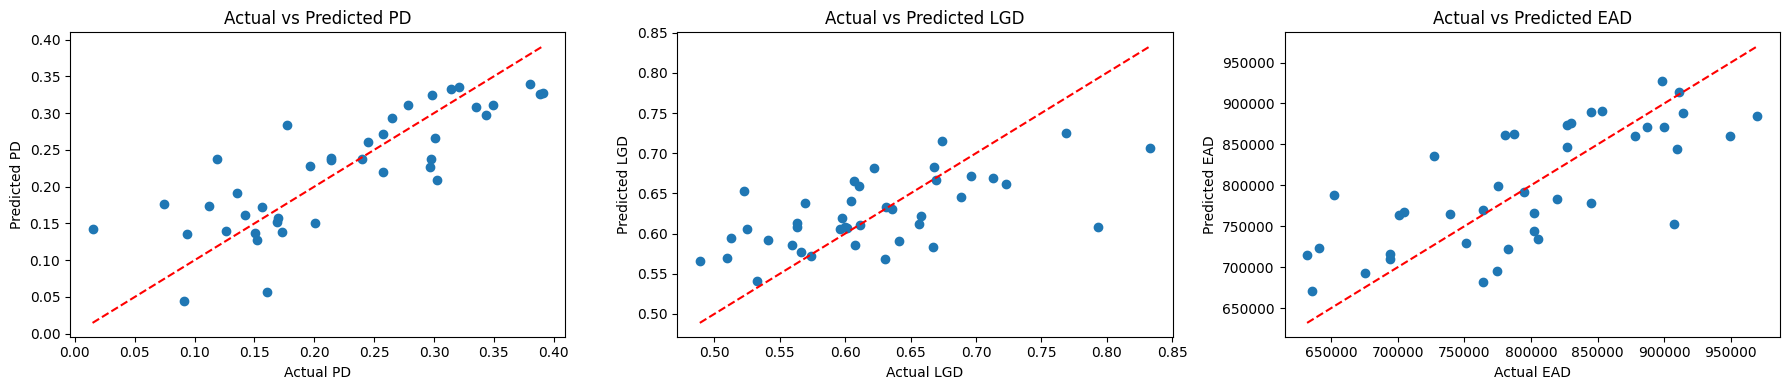

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# PD Plot
pred_PD = model_PD.predict(test_data[features])
axs[0].scatter(test_data['PD'], pred_PD)
axs[0].plot([test_data['PD'].min(), test_data['PD'].max()],
            [test_data['PD'].min(), test_data['PD'].max()],
            color='red', linestyle='--')
axs[0].set_title('Actual vs Predicted PD')
axs[0].set_xlabel('Actual PD')
axs[0].set_ylabel('Predicted PD')

# LGD Plot
pred_LGD = model_LGD.predict(test_data[features])
axs[1].scatter(test_data['LGD'], pred_LGD)
axs[1].plot([test_data['LGD'].min(), test_data['LGD'].max()],
            [test_data['LGD'].min(), test_data['LGD'].max()],
            color='red', linestyle='--')
axs[1].set_title('Actual vs Predicted LGD')
axs[1].set_xlabel('Actual LGD')
axs[1].set_ylabel('Predicted LGD')

# EAD Plot
pred_EAD = model_EAD.predict(test_data[features])
axs[2].scatter(test_data['EAD'], pred_EAD)
axs[2].plot([test_data['EAD'].min(), test_data['EAD'].max()],
            [test_data['EAD'].min(), test_data['EAD'].max()],
            color='red', linestyle='--')
axs[2].set_title('Actual vs Predicted EAD')
axs[2].set_xlabel('Actual EAD')
axs[2].set_ylabel('Predicted EAD')

plt.tight_layout()
plt.show()

## Summary

In this notebook:

- We simulated financial statement data and generated synthetic targets for PD, LGD, and EAD.
- We trained Random Forest models for each risk parameter.
- We used the derived financial ratios for ABC Corp (from the Financial Statement Analyzer outputs) as input features.
- We predicted PD, LGD, and EAD for ABC Corp and calculated the Expected Loss (EL).

This integrated approach demonstrates how to use detailed financial statement outputs to drive data-driven credit risk assessments.
